In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import class_weight
from tensorflow import keras
%matplotlib inline
sns.set_style('white')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/My Drive/Data/')
from analysis_util import *

In [4]:
# with open('../data/resize/X_80.pkl', 'rb') as fp:
#     X_80 = pickle.load(fp)
# with open('../data/resize/y.pkl', 'rb') as fp:
#     y = pickle.load(fp)

In [5]:
with open('/content/drive/My Drive/Data/padded/X_padded_80.pkl', 'rb') as fp:
  X_80 = pickle.load(fp)

with open('/content/drive/My Drive/Data/resize/y.pkl', 'rb') as fp:
  y_classes = pickle.load(fp)

In [6]:
y = np.array(pd.get_dummies(y_classes))

In [7]:
classes = get_classes(y)
cw = dict(enumerate(class_weight.compute_class_weight('balanced', np.unique(classes), classes)))

In [8]:
X_80_train, X_80_test, y_train, y_test = train_test_split(X_80, y, test_size=int(len(y)*.15), random_state=42)
X_80_train, X_80_val, y_train, y_val = train_test_split(X_80_train, y_train, test_size=int(len(y)*.15), random_state=42)

In [9]:
print(len(X_80_train))
print(len(X_80_val))
print(len(X_80_test))

478426
102519
102519


In [10]:
print(len(y_train))
print(len(y_val))
print(len(y_test))

478426
102519
102519


In [11]:
model = keras.models.Sequential()

#Define the input size and rescale all values to be between 0 and 1.
model.add(keras.layers.Input((80,80,1)))
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255))

#A convolutional block
model.add(keras.layers.Convolution2D(32, (3,3), padding='same'))
model.add(keras.layers.MaxPooling2D(2,2, padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Convolution2D(64, (3,3), padding='same'))
model.add(keras.layers.MaxPooling2D(2,2, padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Convolution2D(128, (3,3), padding='same'))
model.add(keras.layers.MaxPooling2D(2,2, padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Convolution2D(256, (3,3), padding='same'))
model.add(keras.layers.MaxPooling2D(2,2, padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# Flatten the last convolutional layer output and connect to 2 fully connected layers and a final output layer (514 classes).
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(5000))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.4))

model.add(keras.layers.Dense(1000))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.4))

model.add(keras.layers.Dense(514, activation='softmax'))

In [12]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-4), metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 80, 80, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 40, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0

In [13]:
history = model.fit(
    np.asarray([np.asarray(x) for x in X_80_train]).reshape(-1,80,80,1), 
    np.array(y_train), 
    epochs=10, 
    batch_size=512, 
    # class_weight=cw,
    validation_data=(np.asarray([np.asarray(x) for x in X_80_val]).reshape(-1,80,80,1).reshape(-1,80,80,1), y_val))

Epoch 1/10
935/935 [==============================] - 80s 85ms/step - loss: 1.7017 - acc: 0.6769 - val_loss: 0.6886 - val_acc: 0.8519
Epoch 2/10
935/935 [==============================] - 79s 85ms/step - loss: 0.5603 - acc: 0.8673 - val_loss: 0.3592 - val_acc: 0.9139
Epoch 3/10
935/935 [==============================] - 79s 85ms/step - loss: 0.3372 - acc: 0.9154 - val_loss: 0.2755 - val_acc: 0.9311
Epoch 4/10
935/935 [==============================] - 79s 85ms/step - loss: 0.2351 - acc: 0.9397 - val_loss: 0.2360 - val_acc: 0.9393
Epoch 5/10
935/935 [==============================] - 79s 85ms/step - loss: 0.1751 - acc: 0.9545 - val_loss: 0.2086 - val_acc: 0.9452
Epoch 6/10
935/935 [==============================] - 79s 85ms/step - loss: 0.1332 - acc: 0.9650 - val_loss: 0.1961 - val_acc: 0.9481
Epoch 7/10
935/935 [==============================] - 79s 85ms/step - loss: 0.1026 - acc: 0.9731 - val_loss: 0.1953 - val_acc: 0.9486
Epoch 8/10
935/935 [==============================] - 79s 85ms

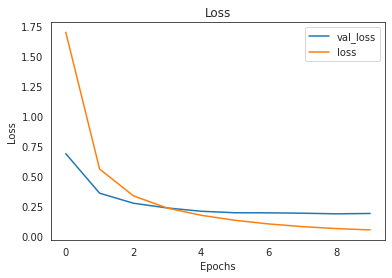

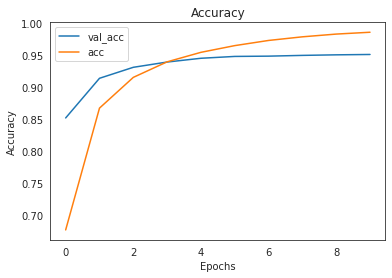

In [14]:
visualize_training_results(history)

In [15]:
# plt.figure(figsize=(20,16))
# sns.heatmap(
#     confusion_matrix(
#         get_classes(y_test), 
#         get_classes(model.predict(np.array(X_80_test).reshape(-1,80,80,1))), 
#         normalize='true'
#     )
# )

In [16]:
## custom classification report

In [17]:
pd.Series(classes).value_counts(normalize=True)

513    0.100027
43     0.036117
46     0.035314
24     0.032495
38     0.030095
         ...   
403    0.000184
367    0.000184
225    0.000184
316    0.000184
82     0.000184
Length: 514, dtype: float64

In [18]:
yhat_test = get_classes(model.predict(np.array([np.asarray(x) for x in X_80_test]).reshape(-1,80,80,1)))
dummy_to_unicode = dict(enumerate(pd.get_dummies(y_classes).columns))

In [26]:
cr = classification_report(get_classes(y_test), yhat_test, output_dict=True)
print(classification_report(get_classes(y_test), yhat_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.98      0.97      0.98       186
           2       0.61      0.67      0.64        69
           3       0.98      0.97      0.98       132
           4       0.94      0.86      0.90       358
           5       0.67      0.72      0.69        25
           6       0.89      0.64      0.75        39
           7       0.97      0.99      0.98       890
           8       0.98      0.99      0.98      1832
           9       0.97      0.96      0.97      1004
          10       0.86      0.91      0.88        96
          11       0.97      0.98      0.98       903
          12       0.94      0.95      0.95      2187
          13       0.97      0.99      0.98       947
          14       0.97      0.97      0.97      1147
          15       0.96      0.89      0.93        92
          16       0.90      0.97      0.93      1361
          17       0.89    

In [20]:
misclassifications = misclass_report(get_classes(y_test), yhat_test, dummy_to_unicode)

In [36]:
for index in misclassifications:
  print(chr(int(dummy_to_unicode[index][2:], 16)) + f' ({cr[str(index)]["support"]}):\t{misclassifications[index]}')
  # print(513)
  # print(misclassifications[index])

▲ (17):	[]
○ (186):	['・', '・', '・', '・', 'rare']
々 (69):	['〻', 'い', 'い', 'く', 'く', 'こ', 'こ', 'こ', 'こ', 'し', 'し', 'し', 'そ', 'も', 'ら', 'ら', 'ら', 'ゝ', 'ゝ', 'ニ', 'レ', '之', '之']
「 (132):	['し', 'し', 'つ', 'rare']
〱 (358):	['〲', '〲', '〲', '〲', '〲', '〲', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'く', 'ぐ', 'で', 'と', 'と', 'に', 'ゝ']
〲 (25):	['〱', '〱', 'ぐ', 'ぐ', 'ぐ', 'で', 'で']
〻 (39):	['々', '々', '々', '々', '々', '々', '々', 'く', 'く', 'と', 'ら', 'ら', 'ヽ', '之']
あ (890):	['お', 'か', 'な', 'な', 'め', '何', '申']
い (1832):	['う', 'お', 'け', 'ち', 'つ', 'の', 'は', 'は', 'は', 'は', 'は', 'ひ', 'り', 'ゝ', 'レ', '・', '以', '以', '以', '以', '行', 'rare']
う (1004):	['か', 'か', 'か', 'か', 'か', 'か', 'か', 'か', 'か', 'か', 'か', 'か', 'こ', 'ま', 'ら', 'ら', 'ら', 'ら', 'ら', 'ら', 'ら', 'ら', 'ら', 'ら', 'ら', 'ら', 'ら', 'ら', 'ら', 'り', 'り', 'り', 'り', 'り', 'り', 'り', 'り']
え (96):	['々', '々', '々', 'く', 'み', 'ゑ', '之

ValueError: ignored

In [33]:
cr['89']

{'f1-score': 0.8409090909090909,
 'precision': 0.8409090909090909,
 'recall': 0.8409090909090909,
 'support': 44}

In [ ]:
# model.save('/content/drive/My Drive/Models/cnn_baseline')

In [ ]:
# model = keras.models.load_model('/content/drive/My Drive/Models/cnn_baseline')

In [ ]:
layer_outputs = [layer.output for layer in model.layers]

In [ ]:
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs[:12])

In [ ]:
X_80_test[200]

In [ ]:
activations = activation_model.predict(np.asarray(X_80_test[200]).reshape(80,80,1))

In [ ]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

In [ ]:
plt.matshow(activations[1][:, :, 0, 10], cmap='plasma')

In [ ]:
sns.set_style('white')

In [ ]:
#First layer activations
fig, axes = plt.subplots(4, 8, figsize=(20, 12))
fig.suptitle(layer_names[4])
for i in range(32):
    row = i//8
    column = i%8
    ax = axes[row, column]
    ax.matshow(activations[4][:, :, 0, i], cmap='plasma')

In [ ]:
#Second layer activations
fig, axes = plt.subplots(8, 8, figsize=(12,24))
fig.suptitle(layer_names[5])
for i in range(64):
    row = i//8
    column = i%8
    ax = axes[row, column]
    ax.matshow(activations[5][:, :, 0, i], cmap='plasma')

In [ ]:
activations[-11].shape

In [ ]:
#Final conv layer activations
fig, axes = plt.subplots(4, 8, figsize=(12,6))
fig.suptitle(layer_names[-11])
for i in range(32):
    row = i//8
    column = i%8
    ax = axes[row, column]
    ax.matshow(activations[-11][:, :, 0, i], cmap='plasma')